In [11]:
#Resolução númerica da equação de Schrodinger por RK2
#Com aplicações

#Danilo Lessa Bernardineli
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integ
import matplotlib.animation as manimation

In [29]:
### Parâmetros das condições iniciais ###
x_c = -0.5
s = 0.05
k_0 = 30

#Parâmetros do potencial barreira
V_0 = 250
x1 = -0.2
x2 = 0

### Parâmetros de simulação ###

#Intervalo no eixo x
x_i = -1
x_f = 1

#Intervalo temporal
t_0 = 0
t_f = 0.05

#Passos
dt = 0.0001
r = 0.075
dx = np.sqrt(dt / (2 * r))
dx2 = 2 * dx ** 2

#Tamanho das matrizes de simulação
Nt = int((t_f - t_0) / dt)
Nx = int((x_f - x_i) / dx)

#Discretização do espaço contínuo
Td = np.arange(Nt)
Xd = np.arange(Nx)

#Representação no espaço contínuo
T = Td * dt
X = (Xd * dx) + x_i

In [30]:
### Funções da simulação ###

def V(i):
    """Potential function for using in the simulation.
    Keyword arguments:
    i -- Potential in the i array position"""
    x = x_i + i * dx
    if x > x1 and x < x2:
        return V_0
    else:
        return 0   

def waveFunction(x):
    """Initial time-indepedent wavefunction.
    Keyword arguments:
    x -- Wavefunction on the x position
    """
    expoent = (-1/2) * (((x - x_c) / s)) ** 2
    return np.exp(1j * k_0 * x) * np.sqrt(np.exp(expoent) / (s * np.sqrt(2 * np.pi)))

def der_R(i, I):
    """Get the real part of the wavefunction derivative."""
    if i == 0:
        return (2*I[i] - I[i+1]) / (dx2) + V(i) * I[i]
    elif i >= len(I) - 1:
        return (2*I[i] - I[i-1]) / (dx2) + V(i) * I[i]    
    else:
        return (2*I[i] - I[i+1] - I[i-1]) / (dx2) + V(i) * I[i]

def der_I(i, R):
    if i == 0:
        return ( R[i+1] - 2*R[i]) / (dx2) - V(i) * R[i]
    elif i >= len(R) - 1:
        return ( R[i-1] - 2*R[i]) / (dx2) - V(i) * R[i]
    else:
        return ( R[i+1] + R[i-1] - 2*R[i]) / (dx2) - V(i) * R[i]
    
def HR(i, R):
    """Real part of the hamiltonian"""
    if i == 0:
        return -( R[i+1] - 2*R[i]) / (dx2) + V(i) * R[i]
    elif i >= len(R) - 1:
        return -( R[i-1] - 2*R[i]) / (dx2) + V(i) * R[i]
    else:
        return -( R[i+1] + R[i-1] - 2*R[i]) / (dx2) + V(i) * R[i]
    
def HI(i, I):
    """Imaginary part of the hamiltonian"""
    if i == 0:
        return (2*I[i] - I[i+1]) / (dx2) + V(i) * I[i]
    elif i >= len(I) - 1:
        return (2*I[i] - I[i-1]) / (dx2) + V(i) * I[i]    
    else:
        return (2*I[i] - I[i+1] - I[i-1]) / (dx2) + V(i) * I[i]

In [31]:
### Inicialização ###
res_R = np.zeros((Nt, Nx))
res_I = np.zeros((Nt, Nx))
res_HR = np.zeros((Nt, Nx))
res_HI = np.zeros((Nt, Nx))
res_N = np.zeros((Nt, Nx)) #Norma
norma = np.zeros(Nt) #Norma antes da renormalização
res_R[0] = np.real(waveFunction(X))
res_I[0] = np.imag(waveFunction(X))

In [32]:
### Resolução númerica ###

#Resolução da função de onda por RK2
for t in Td:
    
    if t == 0:
        continue 
        
    #Listas contendo os valores de meio-intervalo para o RK2
    half_R = np.zeros(Nx)
    half_I = np.zeros(Nx) 
    
    #Primeira parte do RK2 - aproximando a função em meio passo
    for x in Xd:
        
        #Valor da parte real e imaginária da função de onda em t-1
        x0_r = res_R[t - 1, x]
        x0_i = res_I[t - 1, x]
        
        #Derivadas das partes real e imaginária em t-1
        k1_r = der_R(x, res_I[t - 1]) * dt
        k1_i = der_I(x, res_R[t - 1]) * dt
        
        #Aproximação para a parte real e imaginária em t = (t - [t-1])/2
        x1_r = x0_r + k1_r / 2
        x1_i = x0_i + k1_i / 2
        
        #Armazenando o resultado acima
        half_R[x] = x1_r
        half_I[x] = x1_i
    
    #Segunda parte do RK2
    for x in Xd:
        
        #Derivada das partes real e imaginária em (t - [t-1])/2
        k2_r = der_R(x, half_I) * dt
        k2_i = der_I(x, half_R) * dt
        
        #Armazenando a aproximação para a parte real e imaginária em t
        res_R[t, x] = res_R[t - 1, x] + k2_r
        res_I[t, x] = res_I[t - 1, x] + k2_i
        
    #Renormalização
    for x in Xd:
        res_N[t, x] = (res_R[t, x] ** 2 + res_I[t,x] ** 2) * dx
    norma[t] = np.sum(res_N[t])
    #res_R[t] = res_R[t] / norma[t]
    #res_I[t] = res_I[t] / norma[t]     

#Obtenção da energia
for t in Td:
    for x in Xd:
        res_HR[t, x] = HR(x, res_R[t])
        res_HI[t, x] = HI(x, res_I[t])   
        

In [33]:
E_real = np.zeros(Nt)
E_imag = np.zeros(Nt)
Rc = np.zeros(Nt)
Tc = np.zeros(Nt)
for t in Td:
    
    e_t = np.sum((res_R[t] - 1j * res_I[t]) * (res_HR[t] + 1j * res_HI[t])) * dx / norma[t]
    E_real[t] = e_t.real
    E_imag[t] = e_t.imag
    
    for xd in Xd:
        x = x_i + xd * dx
        if x <= x1:
            Rc[t] += res_N[t, xd]
        if x >= x2:
            Tc[t] += res_N[t, xd]
            

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in cdouble_scalars


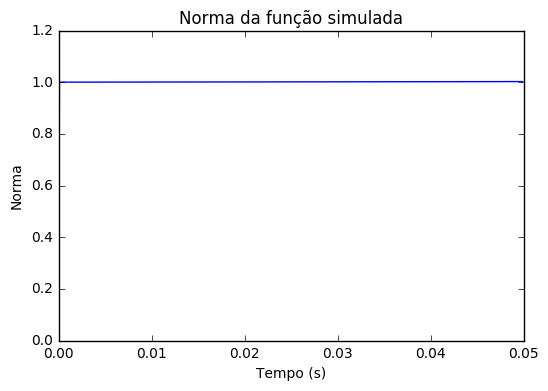

In [34]:
plt.plot(T, norma)
plt.title("Norma da função simulada")
plt.ylabel("Norma")
plt.xlabel("Tempo (s)")
plt.show()

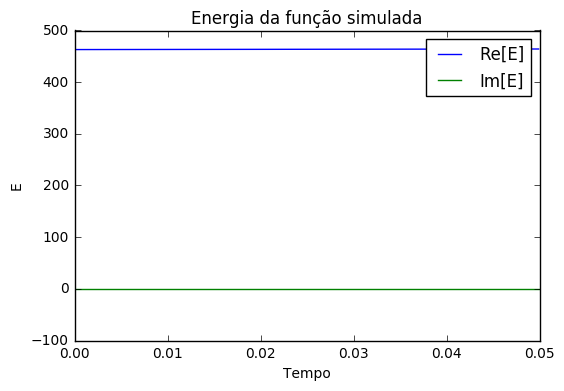

In [35]:
plt.plot(T, E_real, label="Re[E]")
plt.plot(T, E_imag, label="Im[E]")
plt.title("Energia da função simulada")
plt.legend()
plt.ylabel("E")
plt.xlabel("Tempo")
plt.show()

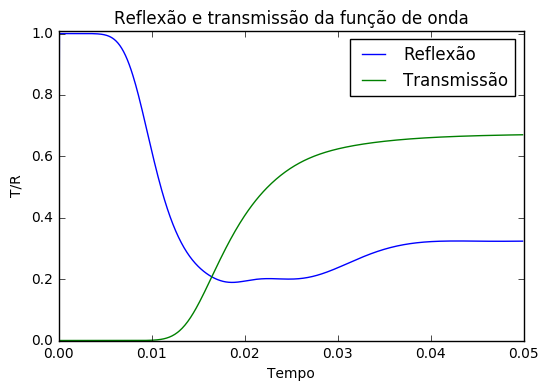

In [36]:
plt.plot(T, Rc, label="Reflexão")
plt.plot(T, Tc, label="Transmissão")
plt.title("Reflexão e transmissão da função de onda")
plt.legend()
plt.ylabel("T/R")
plt.xlabel("Tempo")
plt.ylim((0, 1.01))
plt.show()